End-to-End Summary of the Enhanced Momentum Strategy

1. Objective

        The strategy seeks to capitalize on momentum by selecting the best-performing Dow Jones Industrial Average (DJIA) stocks based on historical returns. It employs risk management enhancements to improve robustness and reduce concentration risks while maintaining competitive returns.

2. Data

        •	Universe: 30 Dow Jones components.
        •	Benchmark: Dow Jones Industrial Average Index (^DJI).
        •	Data Sources: Monthly adjusted closing prices from Yahoo Finance.
        •	Returns: Monthly percentage changes calculated for each stock and the benchmark.

3. Core Strategy

    Baseline: Equal-Weighted Momentum Strategy

        •	Momentum Calculation:
        •	Calculate rolling returns over a fixed 9-month window.
        •	Select the top 3 stocks with the highest rolling returns.
        •	Portfolio Construction:
        •	Equally weight the selected stocks and rebalance monthly.
        •	Performance Metrics:
        •	Sharpe Ratio: Measures risk-adjusted returns.
        •	Max Drawdown: Largest loss from a portfolio peak.
        •	Annualized Return: Geometric mean of yearly returns.

4. Enhancements

    A. Dynamic Momentum Window (Enhancement 1)

        •	Rationale:
        •	Momentum trends are sensitive to market volatility. Adjusting the rolling window dynamically ensures the strategy adapts to changing market conditions.
        •	Implementation:
        •	Use a shorter window (6 months) during high-volatility periods and a longer window (12 months) during low-volatility periods. A default 9-month window is used for moderate volatility.
        •	Impact:
        •	Improved Sharpe ratio and annualized returns compared to the baseline.
        •	Reduced drawdowns during volatile market conditions.

    B. Sector Diversification (Enhancement 2)

        •	Rationale:
        •	Concentration risk arises when the top 3 stocks come from the same sector. Diversification mitigates this risk, ensuring exposure to multiple sectors.
        •	Implementation:
        •	Use a predefined sector mapping to ensure the selected top 3 stocks are from different sectors.
        •	Prioritize the highest-ranked stock in each sector.
        •	Impact:
        •	Slightly lower Sharpe ratio and returns due to reduced exposure to concentrated momentum, but improved risk control with reduced drawdowns.
        •	More stable and diversified portfolio performance.

5. Final Strategy Workflow

    Step 1: Data Preparation

        •	Fetch historical price data for Dow Jones components and calculate monthly returns.
        •	Resample prices to monthly frequency and forward-fill missing data.

    Step 2: Rolling Momentum Calculation

        •	Dynamically calculate rolling returns based on market volatility.
        •	High Volatility: 6-month window.
        •	Low Volatility: 12-month window.
        •	Moderate Volatility: 9-month window.

    Step 3: Stock Selection

        •	Rank stocks by their rolling returns.
        •	Ensure sector diversification by selecting one stock per sector (up to 3).

    Step 4: Portfolio Construction

        •	Equally weight the top 3 selected stocks.
        •	Rebalance monthly based on updated rankings.

    Step 5: Risk and Performance Analysis

        •	Compare the portfolio against the DJI benchmark using:
        •	Sharpe Ratio for risk-adjusted returns.
        •	Max Drawdown to evaluate downside risk.
        •	Annualized Return for overall performance.

6. Final Performance Summary

        •	Dynamic Momentum Window:
        •	Sharpe Ratio: 0.85 (higher risk-adjusted returns).
        •	Max Drawdown: -41.89%.
        •	Annualized Return: 15.91%.
        •	Sector Diversification:
        •	Sharpe Ratio: 0.71 (lower but stable returns).
        •	Max Drawdown: -42.30%.
        •	Annualized Return: 12.16% (slightly reduced but more robust).

7. Key Takeaways

        •	The baseline strategy effectively captures momentum-driven gains but lacks risk controls.
        •	Dynamic momentum adjustment ensures adaptability to market conditions and enhances risk-adjusted returns.
        •	Sector diversification introduces stability by reducing concentration risk, making the strategy more robust for long-term use.
        •	The strategy balances return maximization and risk management, offering a consistent, data-driven approach to momentum investing.


[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


Strategy Sharpe Ratio (Dynamic): 0.85
Benchmark Sharpe Ratio: 0.57
Strategy Max Drawdown (Dynamic): -41.89%
Benchmark Max Drawdown: -49.30%
Strategy Annualized Return (Dynamic): 15.91%
Benchmark Annualized Return: 7.50%


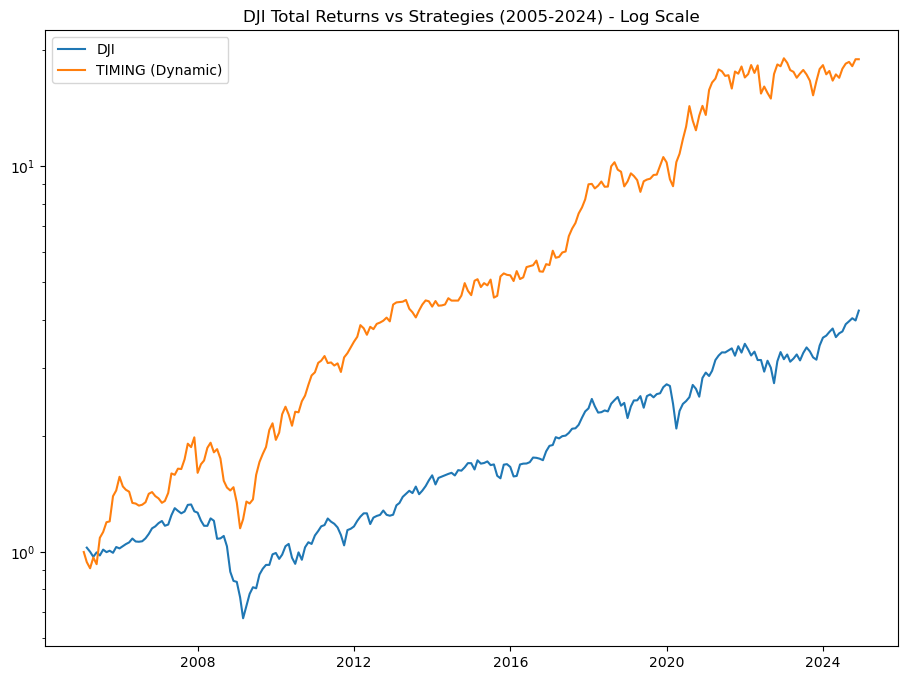

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers for Dow Jones components
tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
           'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
           'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']

# Download monthly adjusted close prices and calculate monthly returns
data = yf.download(tickers, start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

# Download Dow Jones Index (DJI) data for comparison
data['dji'] = yf.download('^DJI', start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

# Fill missing data in `data`
data = data.fillna(method='ffill')  # Forward-fill missing data

# Function to calculate rolling returns
def get_rolling_ret(data, n):
    return data.rolling(n, min_periods=n).apply(np.prod)

# Function to determine dynamic rolling window size based on volatility
def dynamic_window(date, threshold_high=0.02, threshold_low=0.01):
    market_volatility = data['dji'].pct_change().rolling(12).std().loc[date]
    if market_volatility > threshold_high:
        return 6  # High volatility -> shorter window
    elif market_volatility < threshold_low:
        return 12  # Low volatility -> longer window
    else:
        return 9  # Moderate volatility -> default window

# Calculate dynamic rolling returns for all dates in advance
ret_dynamic = pd.DataFrame(index=data.index, columns=data.columns)
for date in data.index:
    window = dynamic_window(date)
    rolling_ret = get_rolling_ret(data, window)
    ret_dynamic.loc[date] = rolling_ret.loc[date]

# Ensure ret_dynamic is numeric
ret_dynamic = ret_dynamic.astype(float).fillna(0)

# Function to get the top-performing stocks (based on dynamic rolling returns)
def get_top_dynamic(date):
    try:
        top_stocks = ret_dynamic.loc[date].nlargest(3).index
        return top_stocks
    except Exception as e:
        print(f"Error on {date}: {e}")
        return pd.Index([])

# Function to calculate portfolio returns for the selected top stocks
def portfolio_ret_dynamic(date):
    top_stocks = get_top_dynamic(date)
    if top_stocks.empty:  # Handle case where no top stocks are returned
        return 0
    portfolio = data.loc[date:, top_stocks][1:2]  # Use top stocks
    return portfolio.mean(axis=1).values[0]

# Initialize a 'returns_dynamic' column for the dynamic strategy
data['returns_dynamic'] = 1.00

# Calculate portfolio returns for each date
for i in range(1, len(data) - 1):
    data['returns_dynamic'][i] = portfolio_ret_dynamic(data.index[i])

# Sharpe Ratio Calculation
def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=12):
    excess_returns = returns - risk_free_rate
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    annualized_mean = returns.mean() * periods_per_year
    return annualized_mean / annualized_volatility

# Maximum Drawdown Calculation
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

# Annualized Return Calculation
def calculate_annualized_return(cumulative_returns, periods_per_year=12):
    total_return = cumulative_returns.iloc[-1] - 1
    n_years = len(cumulative_returns) / periods_per_year
    return (1 + total_return) ** (1 / n_years) - 1

# Convert cumulative returns to monthly returns for metrics
strategy_returns_dynamic = data['returns_dynamic'].cumprod().pct_change()
benchmark_returns = data['dji'].cumprod().pct_change()

# Calculate Sharpe Ratios
strategy_sharpe_dynamic = calculate_sharpe_ratio(strategy_returns_dynamic)
benchmark_sharpe = calculate_sharpe_ratio(benchmark_returns)

# Calculate Maximum Drawdowns
strategy_max_drawdown_dynamic = calculate_max_drawdown(data['returns_dynamic'].cumprod())
benchmark_max_drawdown = calculate_max_drawdown(data['dji'].cumprod())

# Calculate Annualized Returns
strategy_annualized_return_dynamic = calculate_annualized_return(data['returns_dynamic'].cumprod())
benchmark_annualized_return = calculate_annualized_return(data['dji'].cumprod())

# Print metrics for strategy and benchmark
print(f"Strategy Sharpe Ratio (Dynamic): {strategy_sharpe_dynamic:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.2f}")
print(f"Strategy Max Drawdown (Dynamic): {strategy_max_drawdown_dynamic:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Strategy Annualized Return (Dynamic): {strategy_annualized_return_dynamic:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")

# Plot cumulative returns for strategy and benchmark
plt.figure(figsize=[11, 8])
plt.plot(data['dji'].cumprod(), label='DJI')
plt.plot(data['returns_dynamic'].cumprod(), label='TIMING (Dynamic)')
plt.yscale('log')
plt.title('DJI Total Returns vs Strategies (2005-2024) - Log Scale')
plt.legend()
plt.show()

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


Strategy Sharpe Ratio (Diversified): 0.71
Benchmark Sharpe Ratio: 0.57
Strategy Max Drawdown (Diversified): -42.30%
Benchmark Max Drawdown: -49.30%
Strategy Annualized Return (Diversified): 12.16%
Benchmark Annualized Return: 7.50%


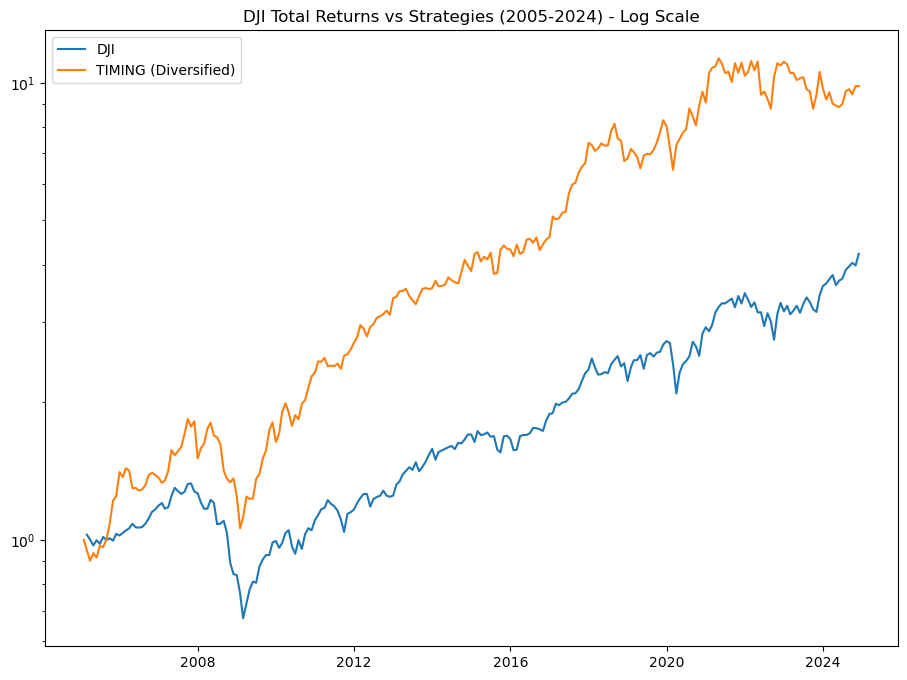

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define tickers for Dow Jones components
tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW',
           'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM',
           'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']

# Sector mapping for Dow Jones components
sectors = {
    'AAPL': 'Technology', 'AMGN': 'Healthcare', 'AXP': 'Financials', 'BA': 'Industrials',
    'CAT': 'Industrials', 'CRM': 'Technology', 'CSCO': 'Technology', 'CVX': 'Energy',
    'DIS': 'Communication Services', 'DOW': 'Materials', 'GS': 'Financials',
    'HD': 'Consumer Discretionary', 'HON': 'Industrials', 'IBM': 'Technology',
    'INTC': 'Technology', 'JNJ': 'Healthcare', 'JPM': 'Financials', 'KO': 'Consumer Staples',
    'MCD': 'Consumer Discretionary', 'MMM': 'Industrials', 'MRK': 'Healthcare',
    'MSFT': 'Technology', 'NKE': 'Consumer Discretionary', 'PG': 'Consumer Staples',
    'TRV': 'Financials', 'UNH': 'Healthcare', 'V': 'Financials', 'VZ': 'Communication Services',
    'WBA': 'Consumer Staples', 'WMT': 'Consumer Staples'
}

# Download monthly adjusted close prices and calculate monthly returns
data = yf.download(tickers, start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

# Download Dow Jones Index (DJI) data for comparison
data['dji'] = yf.download('^DJI', start='2005-01-01')['Adj Close'].resample('M').last().pct_change() + 1

# Fill missing data in `data`
data = data.fillna(method='ffill')

# Function to calculate rolling returns
def get_rolling_ret(data, n):
    return data.rolling(n, min_periods=n).apply(np.prod)

# Function to determine dynamic rolling window size based on volatility
def dynamic_window(date, threshold_high=0.02, threshold_low=0.01):
    market_volatility = data['dji'].pct_change().rolling(12).std().loc[date]
    if market_volatility > threshold_high:
        return 6  # High volatility -> shorter window
    elif market_volatility < threshold_low:
        return 12  # Low volatility -> longer window
    else:
        return 9  # Moderate volatility -> default window

# Calculate dynamic rolling returns for all dates in advance
ret_dynamic = pd.DataFrame(index=data.index, columns=data.columns)
for date in data.index:
    window = dynamic_window(date)
    rolling_ret = get_rolling_ret(data, window)
    ret_dynamic.loc[date] = rolling_ret.loc[date]

# Ensure ret_dynamic is numeric
ret_dynamic = ret_dynamic.astype(float).fillna(0)

# Function to get top-performing stocks with sector diversification
def get_top_diversified(date):
    try:
        top_stocks = ret_dynamic.loc[date].nlargest(len(ret_dynamic.columns)).index
        selected_stocks = []
        seen_sectors = set()
        for stock in top_stocks:
            sector = sectors.get(stock, None)
            if sector not in seen_sectors:
                selected_stocks.append(stock)
                seen_sectors.add(sector)
            if len(selected_stocks) == 3:
                break
        return pd.Index(selected_stocks)
    except Exception as e:
        print(f"Error on {date}: {e}")
        return pd.Index([])

# Function to calculate portfolio returns for diversified stocks
def portfolio_ret_diversified(date):
    top_stocks = get_top_diversified(date)
    if top_stocks.empty:  # Handle case where no top stocks are returned
        return 0
    portfolio = data.loc[date:, top_stocks][1:2]  # Use top stocks
    return portfolio.mean(axis=1).values[0]

# Initialize a 'returns_diversified' column for the diversified strategy
data['returns_diversified'] = 1.00

# Calculate portfolio returns for each date
for i in range(1, len(data) - 1):
    data['returns_diversified'][i] = portfolio_ret_diversified(data.index[i])

# Sharpe Ratio Calculation
def calculate_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=12):
    excess_returns = returns - risk_free_rate
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    annualized_mean = returns.mean() * periods_per_year
    return annualized_mean / annualized_volatility

# Maximum Drawdown Calculation
def calculate_max_drawdown(cumulative_returns):
    cumulative_max = cumulative_returns.cummax()
    drawdown = cumulative_returns / cumulative_max - 1
    return drawdown.min()

# Annualized Return Calculation
def calculate_annualized_return(cumulative_returns, periods_per_year=12):
    total_return = cumulative_returns.iloc[-1] - 1
    n_years = len(cumulative_returns) / periods_per_year
    return (1 + total_return) ** (1 / n_years) - 1

# Convert cumulative returns to monthly returns for metrics
strategy_returns_diversified = data['returns_diversified'].cumprod().pct_change()
benchmark_returns = data['dji'].cumprod().pct_change()

# Calculate Sharpe Ratios
strategy_sharpe_diversified = calculate_sharpe_ratio(strategy_returns_diversified)
benchmark_sharpe = calculate_sharpe_ratio(benchmark_returns)

# Calculate Maximum Drawdowns
strategy_max_drawdown_diversified = calculate_max_drawdown(data['returns_diversified'].cumprod())
benchmark_max_drawdown = calculate_max_drawdown(data['dji'].cumprod())

# Calculate Annualized Returns
strategy_annualized_return_diversified = calculate_annualized_return(data['returns_diversified'].cumprod())
benchmark_annualized_return = calculate_annualized_return(data['dji'].cumprod())

# Print metrics for strategy and benchmark
print(f"Strategy Sharpe Ratio (Diversified): {strategy_sharpe_diversified:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.2f}")
print(f"Strategy Max Drawdown (Diversified): {strategy_max_drawdown_diversified:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Strategy Annualized Return (Diversified): {strategy_annualized_return_diversified:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")

# Plot cumulative returns for strategy and benchmark
plt.figure(figsize=[11, 8])
plt.plot(data['dji'].cumprod(), label='DJI')
plt.plot(data['returns_diversified'].cumprod(), label='TIMING (Diversified)')
plt.yscale('log')
plt.title('DJI Total Returns vs Strategies (2005-2024) - Log Scale')
plt.legend()
plt.show()

In [3]:
# Set initial capital
initial_capital = 1_000_000

# Initialize the portfolio value for the dynamic strategy
data['portfolio_dynamic'] = initial_capital

# Update portfolio value for each date based on dynamic returns
for i in range(1, len(data)):
    data['portfolio_dynamic'].iloc[i] = data['portfolio_dynamic'].iloc[i - 1] * data['returns_dynamic'].iloc[i]

# Calculate portfolio value for the benchmark (DJI)
data['portfolio_dji'] = initial_capital
for i in range(1, len(data)):
    data['portfolio_dji'].iloc[i] = data['portfolio_dji'].iloc[i - 1] * data['dji'].iloc[i]

# Sharpe Ratio Calculation (based on portfolio percentage returns)
strategy_returns_dynamic = data['portfolio_dynamic'].pct_change()
benchmark_returns = data['portfolio_dji'].pct_change()

# Recalculate Sharpe Ratios
strategy_sharpe_dynamic = calculate_sharpe_ratio(strategy_returns_dynamic)
benchmark_sharpe = calculate_sharpe_ratio(benchmark_returns)

# Maximum Drawdown Calculation (based on portfolio value)
strategy_max_drawdown_dynamic = calculate_max_drawdown(data['portfolio_dynamic'])
benchmark_max_drawdown = calculate_max_drawdown(data['portfolio_dji'])

# Annualized Return Calculation (based on portfolio value)
strategy_annualized_return_dynamic = calculate_annualized_return(data['portfolio_dynamic'])
benchmark_annualized_return = calculate_annualized_return(data['portfolio_dji'])

# Print metrics for strategy and benchmark
print(f"Strategy Sharpe Ratio (Dynamic): {strategy_sharpe_dynamic:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.2f}")
print(f"Strategy Max Drawdown (Dynamic): {strategy_max_drawdown_dynamic:.2%}")
print(f"Benchmark Max Drawdown: {benchmark_max_drawdown:.2%}")
print(f"Strategy Annualized Return (Dynamic): {strategy_annualized_return_dynamic:.2%}")
print(f"Benchmark Annualized Return: {benchmark_annualized_return:.2%}")

# Plot portfolio value over time
plt.figure(figsize=[11, 8])
plt.plot(data['portfolio_dji'], label='Benchmark (DJI)')
plt.plot(data['portfolio_dynamic'], label='Strategy (Dynamic)')
plt.title('Portfolio Value Over Time (2005-2024)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()


KeyError: 'returns_dynamic'

In [ ]:
# Function to calculate annualized return in dollars
def calculate_annualized_return_dollars(initial_capital, annualized_return, n_years):
    return initial_capital * ((1 + annualized_return) ** n_years - 1)

# Number of years in the backtest period
n_years = len(data) / 12  # Assuming monthly data

# Calculate annualized return in dollars for the strategy and benchmark
strategy_annualized_return_dollars = calculate_annualized_return_dollars(
    initial_capital, strategy_annualized_return_dynamic, n_years
)
benchmark_annualized_return_dollars = calculate_annualized_return_dollars(
    initial_capital, benchmark_annualized_return, n_years
)

# Print the annualized return in dollars
print(f"Strategy Annualized Return (Dynamic) in Dollars: ${strategy_annualized_return_dollars:,.2f}")
print(f"Benchmark Annualized Return in Dollars: ${benchmark_annualized_return_dollars:,.2f}")


Strategy Annualized Return (Dynamic) in Dollars: $18,929,268,461,054.28
Benchmark Annualized Return in Dollars: $4,222,760,036,219.70
